In [23]:
# libraries for data manipulation and exploration
import pandas as pd
import numpy as np

# for text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Conv2D, MaxPooling1D, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold
#from keras.optimizers import Adam
import nltk
import tensorflow as tf
from sklearn.linear_model import Lasso
#nltk.download('omw-1.4')

In [5]:
data = pd.read_csv(r'/content/data.csv')
#data.head
#data.info()
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

# making a bar plot to count the frequency of 
# fake and real news
#sns.countplot(x='Label', 
 #             data=data,
  #            palette=['#ffaec0', '#b8b5ff'],
   #           saturation=1)
#sns.despine()
#plt.xticks([0,1], ['Fake', 'Real'])
#plt.title('Fake Vs Real news');

In [6]:
fake_news_count = data[data.Label == 0]['Website'].value_counts()
real_news_count = data[data.Label == 1]['Website'].value_counts()

fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})

rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count

,Web,Real,Fake
0,www.reuters.com,646,0
1,www.cnn.com,389,0
2,www.nytimes.com,341,0
3,www.bbc.com,333,0
4,abcnews.go.com,57,0
5,money.cnn.com,49,0
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,www.bbc.co.uk,10,0
9,bleacherreport.com,8,0


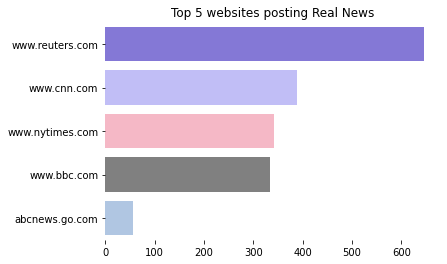

In [7]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

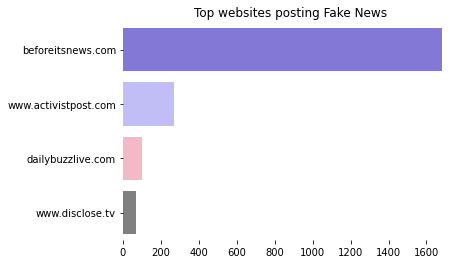

In [8]:
sns.barplot(y=fake_news_count.index, x=fake_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Fake News');

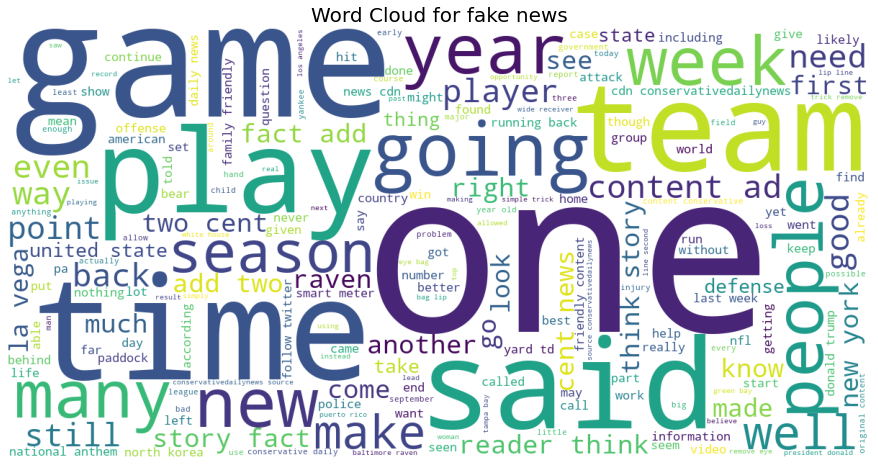

In [9]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus    

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

sw = set(STOPWORDS)

fake_news = data[data.Label == 0]
real_news = data[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(fake_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(fake_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for fake news', fontsize=20);



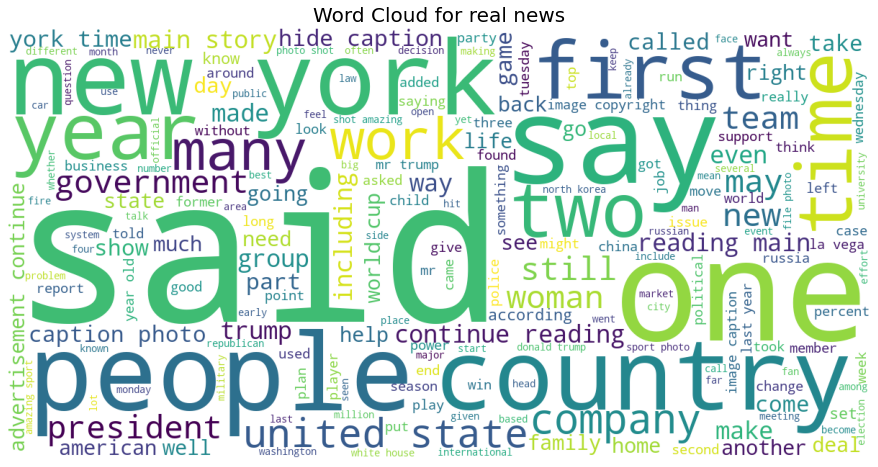

In [10]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(real_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(real_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for real news', fontsize=20);

In [11]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


count    3988.000000
mean      289.271063
std       289.423529
min        10.000000
25%        65.000000
50%       217.000000
75%       419.000000
max      3171.000000
dtype: float64

In [13]:
# taking sentences length as 400
sent_length = 400
# padding
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[3606, 4453, 2959, ...,  268,  850, 3641],
       [   0,    0,    0, ..., 4526, 4858, 1916],
       [ 505, 1657, 1174, ..., 3825, 3607, 4915],
       [   0,    0,    0, ..., 3730, 3945,   67],
       [   0,    0,    0, ..., 2466, 1023, 1088]], dtype=int32)

In [14]:
x = np.array(embedded_doc)
y = data.Label


las = Lasso(alpha=1.0)
las.fit(x, y)

Lasso()

In [22]:
def create_model( dropout_rate):
  model = Sequential()
# adding embedding layer
  model.add(Embedding(5000, 100, input_length=sent_length))
  model.add(LSTM(150))
  model.add(Dense(1, activation='sigmoid'))
  model.add(Dropout(dropout_rate))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

  # Declare parameter values
dropout_rate = 0.1
epochs = 1
batch_size = 20
learn_rate = 0.001

# Create the model object by calling the create_model function we created above
model = create_model(dropout_rate)

# Fit the model onto the training data
model.fit(x, y, batch_size=batch_size, epochs=epochs, verbose=1)

200/200 [==============================] - 119s 557ms/step - loss: 0.9191 - accuracy: 0.8781


In [26]:
# Create the model
model = KerasClassifier(build_fn=create_model, verbose=1)

# Define the parameters that you wish to use in your Grid Search along
# with the list of values that you wish to try out
learn_rate = [0.001, 0.02, 0.2]
dropout_rate = [0.0, 0.2, 0.4]
batch_size = [10, 20, 30]
epochs = [1, 5, 10]

seed = 42

# Make a dictionary of the grid search parameters
param_grid = dict(dropout_rate=dropout_rate, batch_size=batch_size, epochs=epochs )

# Build and fit the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=KFold(random_state=None),verbose=10)

grid_results = grid.fit(x, y)

# Summarize the results in a readable format
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
80/80 [==============================] - 9s 101ms/step - loss: 0.1922 - accuracy: 0.9424
[CV 1/5; 1/27] END batch_size=10, dropout_rate=0.0, epochs=1;, score=0.942 total time= 2.3min
[CV 2/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
80/80 [==============================] - 8s 100ms/step - loss: 0.1082 - accuracy: 0.9699
[CV 2/5; 1/27] END batch_size=10, dropout_rate=0.0, epochs=1;, score=0.970 total time= 2.5min
[CV 3/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
80/80 [==============================] - 9s 100ms/step - loss: 0.0929 - accuracy: 0.9699
[CV 3/5; 1/27] END batch_size=10, dropout_rate=0.0, epochs=1;, score=0.970 total time= 2.2min
[CV 4/5; 1/27] START batch_size=10, dropout_rate=0.0, epochs=1..................
80/80 [==============================] - 9s 102ms/step - loss: 0.

KeyboardInterrupt: ignored

In [26]:
pred = (model.predict(test_x) > 0.5).astype("int32")

print ( classification_report(pred, test_y))

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);  

In [26]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# initializing model
model1 = Sequential()
# adding embedding layer
model1.add(Embedding(5000, 100, input_length=sent_length))
model1.add(Conv1D(filters=28,kernel_size=7,activation='relu'))
MaxPooling1D(pool_size=2) 
Dropout(0.3)
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

In [26]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=64)

In [26]:
pred1 = (model1.predict(test_x) > 0.5).astype("int32")

print ( classification_report(pred, test_y))

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);

In [26]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model3 = Sequential()
# adding embedding layer
model3.add(Embedding(5000, 100, input_length=sent_length))
model3.add(SimpleRNN(150))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

In [26]:
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

# fitting the model
history = model3.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=64)

In [ ]:
pred = (model.predict(test_x) > 0.5).astype("int32")

print ( classification_report(pred, test_y))

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15); 

In [26]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()